In [22]:
# Run once if needed
#!pip install avro-python3
#!pip install fastavro
#!pip install astropy

In [23]:
#Import python libraries
import os
import io
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import fastavro
#import aplpy

from astropy.time import Time
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
#from avrhttp://localhost:8888/notebooks/hacky_boi.ipynb#o.datafile import DataFileReader, DataFileWriter
#from avro.io import DatumReader, DatumWriter
#import aplpy

# Handling data

In [24]:
# For making pandas dataframe from packet in .avro
def make_dataframe(packet):
    df = pd.DataFrame(packet['candidate'], index=[0])
    df_prv = pd.DataFrame(packet['prv_candidates'])
    return pd.concat([df,df_prv], ignore_index=True)  

# Lightcurve class handles reading in .avro files and stores them in the class
class lightcurve:
   def __init__(self, avro_filename):
      fake = 0
      self.name = avro_filename # name of file
      
      # Load data from .avro
      with open(avro_filename,'rb') as f:
        freader = fastavro.reader(f)
        schema = freader.schema
        #print('N packets = ', size(freader))
        for packet in freader:
            fake = 0;

      # Remove "null" datapoints, any band besides R band, and bad data points
      dflc = make_dataframe(packet) 
      gooddata =  ~dflc.magpsf.isnull() & (dflc.fid == 2) & (dflc.rb > 0.2) # Remove everything but r band

      # Store time (jd), magnitude, and standard deviation of mag in object
      jd = dflc.jd.values[gooddata] 
      mag = pd.to_numeric(dflc.loc[gooddata,'magpsf']).values
      sigma = pd.to_numeric(dflc.loc[gooddata,'sigmapsf']).values
    
      # Put all points in order of time
      rb = pd.to_numeric(dflc.rb)
      sort_i = jd.argsort() 
      self.jd = jd[sort_i]
      self.mag = mag[sort_i]
      self.sigma = sigma[sort_i]
      self.rb = rb[sort_i]
    
   # Plotting the curve
   def plot(self,  days_ago=True, color='black'):    
      if days_ago:
           now = Time.now().jd
           t = self.jd - now
           xlabel = 'Days Ago'
      else:
           t = self.jd
           xlabel = 'Time (JD)'
    
      plt.errorbar(t, self.mag, self.sigma, fmt='.', color=color)    
      plt.gca().invert_yaxis()
      plt.xlabel(xlabel)
      plt.ylabel('Magnitude')

### Get some data from here: https://ztf.uw.edu/alerts/public/

In [25]:
# Lightcurve example
#avroFile = '2018_11_10_678165691815010013.avro'
#with open(avroFile,'rb') as f:
#    freader = fastavro.reader(f)
    #schema = freader.schema

#    for packet in freader:
#        print(packet.keys())
#
## look at the data
#dflc = make_dataframe(packet)
#dflc.head()

In [26]:
# Plot the curve
#plot_lightcurve(dflc)

# LSTM networks for time series data
Use ptf lightcurve data to train an lstm network 

In [27]:
# GPU check
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

GPU device not found


## Load training data from ptf
-Currently don't have labeled ztf data

-Data read as pickle file

-Contains type, time, magnitude

## Types:
1. AGN
2. Supernova
3. Variable Stars

In [28]:
# Read and examine data
data = pd.read_pickle("training_set.txt")
data.head()

,type,time,mag
0,1,"[56786.448, 56786.476, 56787.454, 56787.484, 5...","[12.884983465735825, 12.699984669427256, 12.33..."
1,1,"[57537.462, 57544.448, 57544.448, 57548.458, 5...","[11.669014494545063, 16.58897151134629, 8.6199..."
2,1,"[56338.563, 56370.464, 56374.445, 56374.475, 5...","[7.457004922589953, 2.80779343375397, 31.92399..."
3,1,"[56505.46, 56511.266, 56516.253, 56519.273, 56...","[10.094977617229535, 5.250029874045033, 3.3913..."
4,1,"[56521.363, 56549.233, 56566.112, 56596.113]","[6.102023335304666, 6.5719951880780325, 5.2973..."


In [29]:
# ml imports
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten 
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#from livelossplot import PlotLossesKeras

## Prepare data
TODO: Remove training data with less than n points then do resizing stuff, some only have 1/2 points
Those with like 1/2 points will be pretty useless for training

In [34]:
# Separate into types
agn0 = data[data.type == 1] # agn
s    = data[data.type == 2] # supernova
vs   = data[data.type == 3] # var stars

# Into numpy array
agn = np.asarray(agn0) # len(agn) = 234
s   = np.asarray(s)    # len(s)   = 872
vs  = np.asarray(vs)   # len(vs)  = 9332

# Shape of data before filtering out low # points 
print('Num points before filtering:')
print('s:   ',s.shape)
print('agn: ',agn.shape)
print('vs:  ',vs.shape) 

# Remove lightcurves with small num of points
minPoints = 6
s_good = []
for i in range(len(s)-1):
    if len(s[i,2]) > minPoints:
        s_good.append(s[i,:])

agn_good = []
for i in range(len(agn)-1):
    if len(agn[i,2]) > minPoints:
        agn_good.append(agn[i])

vs_good = []
for i in range(len(vs)-1):
    if len(vs[i,2]) > minPoints:
        vs_good.append(vs[i])
        
s   = np.asarray(s_good)
agn = np.asarray(agn_good)
vs  = np.asarray(vs_good)

# Shape of data after filtering out low # points 
print('\nNum points after filtering:')
print('s:   ',s.shape)
print('agn: ', agn.shape)
print('vs:  ',vs.shape) 

Num points before filtering:
s:    (872, 3)
agn:  (234, 3)
vs:   (9332, 3)

Shape after filtering:
s:    (728, 3)
agn:  (196, 3)
vs:   (6709, 3)


### Deal with disproportionate data

In [35]:
# Resize to keep equal num of data points
#TODO: find a way to use disproportionate data (use minSize random samples from each after each epoch for training?)
minSize = min(len(agn),len(s),len(vs))
agn = agn[0:minSize,:]
s   = s[0:minSize,:] 
vs  = vs[0:minSize,:]

# Separate labels and data
# Only grabbing magnitude for data
agn_lab  = agn[:,0]
agn_data = agn[:,2]

s_lab   =   s[:,0]
s_data  =   s[:,2]

vs_lab   = vs[:,0]
vs_data  = vs[:,2]        

### Examine num points in lightcurve data

In [36]:
# View size of lc data
all_lens = []

s_lens = []
for i in range(len(s_data)):
    s_lens.append(len(s_data[i]))
    all_lens.append(len(s_data[i]))
print('Median # points in supernova curves: ',np.median(s_lens))
print('Mean # points in supernova curves:   ',np.mean(s_lens))
                                                      
agn_lens = []
for i in range(len(agn_data)):
    agn_lens.append(len(agn_data[i]))
    all_lens.append(len(agn_data[i]))
print('\nMedian # points in agn curves: ',np.median(agn_lens))
print('Mean # points in agn curves:   ',np.mean(agn_lens))
                                                      
vs_lens = []
for i in range(len(vs_data)):
    vs_lens.append(len(vs_data[i]))
    all_lens.append(len(vs_data[i]))
print('\nMedian # points in var star curves: ',np.median(vs_lens))
print('Mean # points in var star curves:   ',np.mean(vs_lens))

print('\nMedian #: ',np.median(all_lens))
print('Mean #:   ',np.mean(all_lens))
medianP = np.median(all_lens)
meanP   = np.mean(all_lens)

Median # points in supernova curves:  35.0
Mean # points in supernova curves:    53.86224489795919

Median # points in agn curves:  47.0
Mean # points in agn curves:    87.86224489795919

Median # points in var star curves:  27.0
Mean # points in var star curves:    53.933673469387756

Median #:  36.0
Mean #:    65.21938775510205


### View some training plots

(49,) (49,)
(170,) (170,)
(10,) (10,)


Text(0.5,1,'var star example')

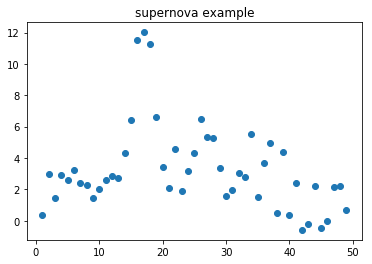

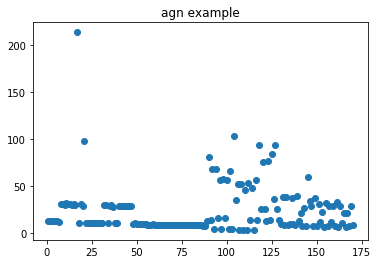

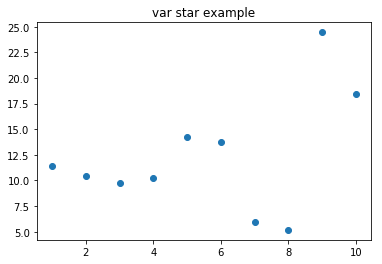

In [52]:
# supernova
steps = np.linspace(1,len(s_data[0]-1),num = len(s_data[0]))
plt.scatter(steps,s_data[0])
plt.title('supernova example')

# agn
plt.figure()
steps = np.linspace(1,len(agn_data[0]-1),num = len(agn_data[0]))
plt.scatter(steps,agn_data[0])
plt.title('agn example')

# var stars
plt.figure()
steps = np.linspace(1,len(vs_data[0]-1),num = len(vs_data[0]))
plt.scatter(steps,vs_data[0])
plt.title('var star example')

### Padding for data, one hot encoding for labels

In [37]:
# Add padding for timesteps since curves will have different number of points
#TODO: Should this padding number be based on mean/median of training data? of ztf data?
maxlen = int(medianP) # based on training data
agn_pad = sequence.pad_sequences(agn_data, maxlen=maxlen)
s_pad   = sequence.pad_sequences(s_data, maxlen=maxlen)
vs_pad  = sequence.pad_sequences(vs_data, maxlen=maxlen)

# All data for each type now size minSize x maxlen
# Move all data into one array
x = np.vstack((s_pad,agn_pad,vs_pad))

# One hot encoding boi for labels
# Keras one hot encoding needs to be 0 indexed but labels are currently 1,2,3
# make them 0 (agn), 1 (supernova), 2 (var stars)
agn_lab = agn_lab-1
s_lab   = s_lab-1
vs_lab  = vs_lab-1

labels = np.hstack((s_lab,agn_lab,vs_lab))           # All labels in one long array (same order we stacked data)
y = keras.utils.to_categorical(labels,num_classes=3) # y data now nx3 arrays, ex: y[0] = [0 1 0]

print('Data shape:   ',x.shape)
print('Labels shape: ',y.shape)

Data shape:    (588, 36)
Labels shape:  (588, 3)


### Train Test Split

In [38]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split( 
        x, y, test_size=0.15)

# Input to lstm must be 3 dimensional (nSamples,timesteps,features)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

print('Train Data shape: ',X_train.shape)
print('Test Data shape:  ',X_test.shape)

Train Data shape:  (499, 36, 1)
Test Data shape:   (89, 36, 1)


## Create and Train model

In [53]:
# model params
num_classes = y.shape[1]
batch_size = 1

# Create model
model = Sequential()
model.add(LSTM(5, batch_input_shape = (batch_size,X_train.shape[1],1), return_sequences=True, stateful=True))
#model.add(LSTM(60, return_sequences=True, stateful=True))
model.add(LSTM(5, stateful=True))
model.add(Dense(num_classes, activation='softmax'))

#model.compile(loss = "mean_squared_error", optimizer = "adam")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
#model.fit(train_X, train_Y, epochs = 100, batch_size = 10, verbose = 2)
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, batch_size=1,verbose = 2)

# Evaluate
score = model.evaluate(X_test, y_test, batch_size=1)
print('Test accuracy: ', score[1])

# save model
#keras.models.save_model('model.hd5')

Train on 499 samples, validate on 89 samples
Epoch 1/50
 - 46s - loss: 1.1044 - acc: 0.3186 - val_loss: 1.0885 - val_acc: 0.3820
Epoch 2/50
 - 42s - loss: 1.0755 - acc: 0.4289 - val_loss: 1.0130 - val_acc: 0.5169
Epoch 3/50
 - 120s - loss: 1.0416 - acc: 0.4469 - val_loss: 0.9830 - val_acc: 0.5281
Epoch 4/50
 - 16s - loss: 1.0360 - acc: 0.4289 - val_loss: 0.9855 - val_acc: 0.5393
Epoch 5/50
 - 15s - loss: 1.0294 - acc: 0.4509 - val_loss: 0.9876 - val_acc: 0.4944
Epoch 6/50
 - 14s - loss: 1.0192 - acc: 0.4489 - val_loss: 0.9736 - val_acc: 0.5506
Epoch 7/50
 - 14s - loss: 1.0215 - acc: 0.4549 - val_loss: 0.9801 - val_acc: 0.4944
Epoch 8/50
 - 13s - loss: 1.0204 - acc: 0.4529 - val_loss: 1.0221 - val_acc: 0.4494
Epoch 9/50
 - 13s - loss: 1.0112 - acc: 0.4489 - val_loss: 0.9790 - val_acc: 0.5281
Epoch 10/50
 - 13s - loss: 1.0042 - acc: 0.4589 - val_loss: 0.9802 - val_acc: 0.4607
Epoch 11/50
 - 14s - loss: 1.0011 - acc: 0.4830 - val_loss: 1.0130 - val_acc: 0.4494
Epoch 12/50
 - 14s - loss: 0

## Using the model to predict a new lightcurve

In [0]:
# 
model = keras.models.load_model('model.hd5')

#l = lightcurve('575406494915010184.avro')
#mag = l.mag

# add padding for time steps
#maxlen = 50
#mag_pad = sequence.pad_sequences(mag_data, maxlen=maxlen)
#data = np.reshape(mag_pad,(mag_pad.shape[0],mag_pad.shape[1],1))
test = X_test[0,:,:]
test = sequence.pad_sequences(test, maxlen=maxlen)
test = np.reshape(test,(test.shape[0],test.shape[1],1))
print(test.shape)
model.predict(test,batch_size = 1)
